# Stock Analysis
This is a much obligated stock analysis project since every data science person must have done some sort of stock analysis throughout their education. This is my version of what I have learned

In [1]:
# importing useful packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
%matplotlib inline

In this analysis, I am using the Alpha Vantage API. Alpha Vantage API gives you realtime/historical stock data, Forex and Crypto currency fees, and many others. In my use case, I will only be grabbing stock information for a random company.
<br><br>
https://www.alphavantage.co/

In [2]:
# grabbing my api key
with open("av_api_key.txt", "r") as f:
    api_key = f.read().strip()
    f.close()

In [3]:
# extract data from API and return dataframe
def extract_data(ticker, api_key=api_key):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={}&outputsize=full&apikey={}".format(ticker, api_key)
    df = pd.DataFrame(requests.get(url).json()["Time Series (Daily)"]).transpose()
    df.columns = ["open", "high", "low", "close", "volume"]
    return df

I have decided to do my analysis on Twilio because I knew it jumped a lot towrads the end of 2019

In [4]:
twlo = extract_data("TWLO")

In [5]:
twlo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, 2020-04-17 to 2016-06-23
Data columns (total 5 columns):
open      961 non-null object
high      961 non-null object
low       961 non-null object
close     961 non-null object
volume    961 non-null object
dtypes: object(5)
memory usage: 45.0+ KB


When data was read in, we can see that the datatype was inferred as objects. However, they are suppose to be numerical. Therefore, I am converting them to floats.

In [6]:
# convert to float
twlo = twlo.apply(lambda x: x.astype(float), axis=1)

In [7]:
twlo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 961 entries, 2020-04-17 to 2016-06-23
Data columns (total 5 columns):
open      961 non-null float64
high      961 non-null float64
low       961 non-null float64
close     961 non-null float64
volume    961 non-null float64
dtypes: float64(5)
memory usage: 45.0+ KB


As we can see, most recent data is at the top. I want to reverse the order.

In [8]:
# reversing the order by sorting the index
twlo.sort_index(inplace=True)

In [9]:
twlo.head()

,open,high,low,close,volume
2016-06-23,23.99,29.6100,23.66,28.79,21299009.0
2016-06-24,27.54,28.7390,26.05,26.30,4670689.0
2016-06-27,27.35,28.1900,26.30,27.25,3929574.0
2016-06-28,30.40,33.4114,29.57,29.92,10620519.0
2016-06-29,31.98,37.1900,31.75,37.08,13782994.0


# EDA
Now that we have the dataframe ready, time to explore the data. First, I want to plot out the open and close prices to see if they differ.

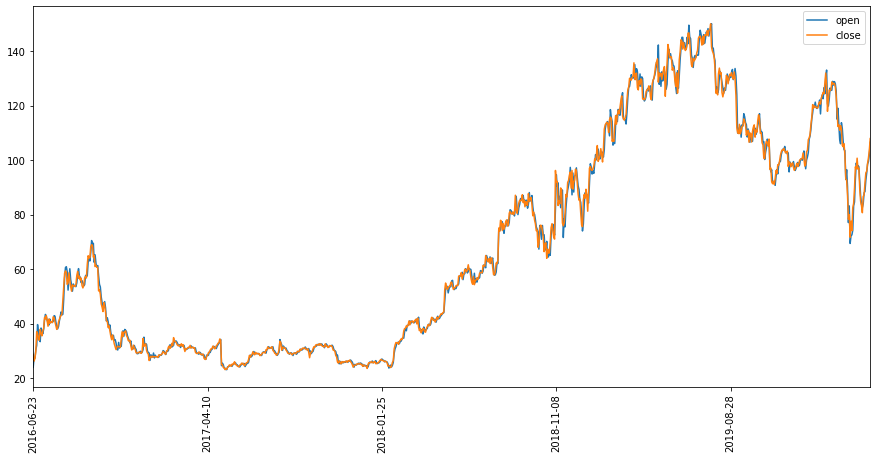

In [10]:
# plotting the open and close price
twlo[["open", "close"]].plot(figsize=(15, 7), rot=90);

The overall plot shows that the plot has its up and downs. I want to further filter the data to look at more recent prices. I will limit it from October of 2018 to now since we can see that starting around that time, the stock is trending upward.

In [11]:
# taking data from october and on
twlo_short = twlo.loc["2018-10-01":]

In [12]:
twlo_short.head()

,open,high,low,close,volume
2018-10-01,87.00,87.550,83.1977,83.75,2150822.0
2018-10-02,83.00,83.630,78.5900,79.57,2844587.0
2018-10-03,80.35,81.820,79.6300,80.90,2026786.0
2018-10-04,80.16,80.495,76.0925,78.09,2458719.0
2018-10-05,78.15,79.990,74.6000,76.62,2516979.0


### Rolling (Moving) average analysis
Moving average, in stocks, tells us the trend in the prices' movement and removes the noise in our data. The direction given by the moving average allows us to understand the performance of the stock better.<br><br>
Reference:<br>
1. https://www.investopedia.com/terms/m/movingaverage.asp<br>
2. https://www.investopedia.com/articles/active-trading/052014/how-use-moving-average-buy-stocks.asp

In [13]:
# Simple Moving Average
# we are going to lag 50 days and 200 days
fifty_days_mv = twlo_short.close.rolling(window=50).mean()
two_hundred_days_mv = twlo_short.close.rolling(window=200).mean()

In [14]:
# check starting date of thw long term rolling average
two_hundred_days_mv.dropna().head()

2019-07-18    111.16090
2019-07-19    111.47025
2019-07-22    111.80970
2019-07-23    112.13305
2019-07-24    112.48065
Name: close, dtype: float64

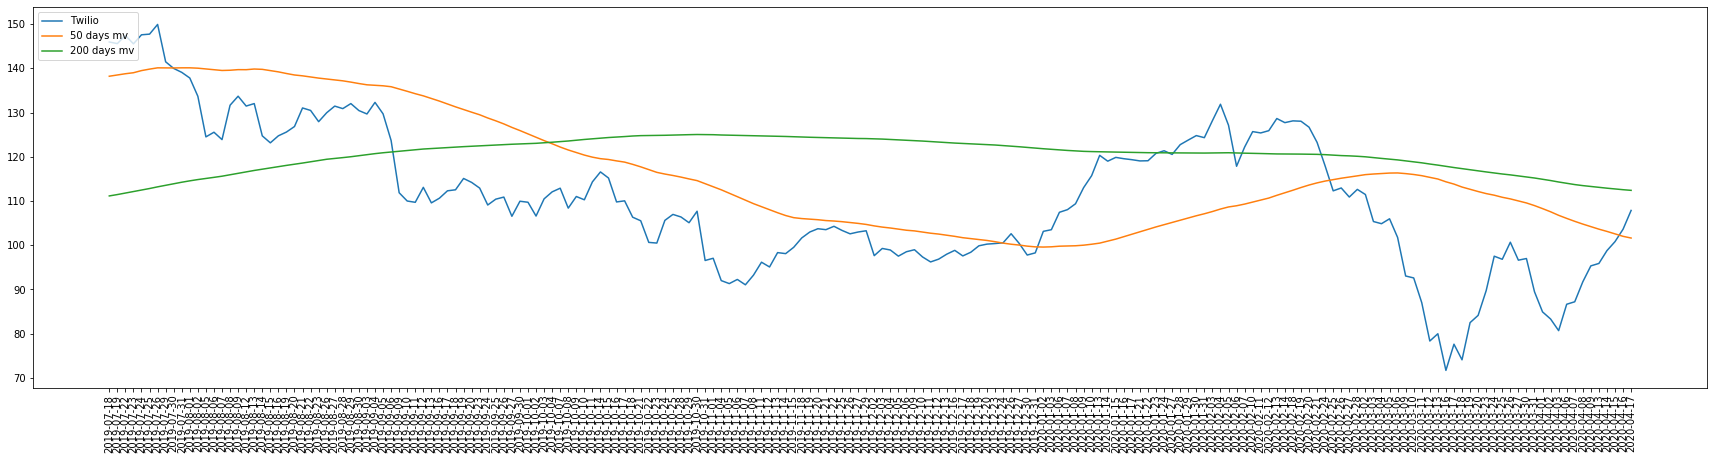

In [15]:
# plot out the moving average against original stock price
plt.figure(figsize=(30, 7));
plt.plot(twlo_short.loc["2019-07-18":].dropna().close, label="Twilio");
plt.plot(fifty_days_mv.loc["2019-07-18":].dropna(), label="50 days mv");
plt.plot(two_hundred_days_mv.dropna(), label="200 days mv");
plt.xticks(rotation=90);
# plt.gca().axes.get_xaxis().set_visible(False);
plt.legend(loc="upper left");

### Explaining the moving averages:
according to our references, when the short term mv (orange line) crosses the long term mv (green line) in a downward manner, it is a sell signal. Therefore, it would be smart to sell this stock around the beginning of October of 2019. Looking further down the road, it seems the short term mv will cross the long term mv soon (maybe sometimes in March of 2020). This may signal a good time to purchase this stock again.<br><br>
### My own two cents:
I think the sell signal makes sense since the stock has been falling in price since July of 2019. If we were to sell this stock in October of 2019, we are able to save ourselves from further price drops as we can see that the stock continues to drop until 2020. However, moving average is not always the best way to determine when to buy or when to sell.

---

# Exponentially Weighted Moving Average (EWMA)
Simply put, EWMA weighs recent data heavier than past data. For example, stock price at 2020-03-05 weighs more than 2020-02-05. This will help us react better to the newest information.

References:
https://www.investopedia.com/articles/07/ewma.asp

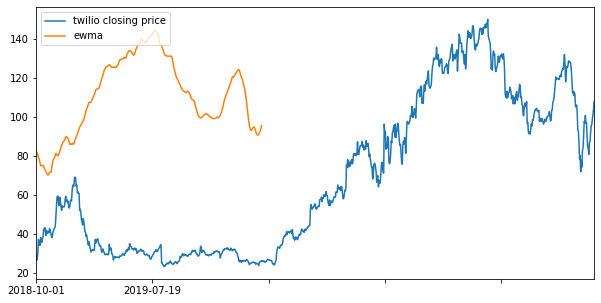

In [16]:
# we will continue to use closing price
twlo.close.plot(label="twilio closing price");
twlo_short.close.ewm(span=20).mean().plot(figsize=(10,5), label='ewma');
plt.legend(loc="upper left");

# Using Markov Chain to predict price
We can use Markov Chain to do a random walk and see what the price may be a few days into the future. I will be implementing Geometric Brownian Motion (GBM), a form of MCMC.

References:
https://www.investopedia.com/articles/07/montecarlo.asp

In [17]:
twlo.head()

,open,high,low,close,volume
2016-06-23,23.99,29.6100,23.66,28.79,21299009.0
2016-06-24,27.54,28.7390,26.05,26.30,4670689.0
2016-06-27,27.35,28.1900,26.30,27.25,3929574.0
2016-06-28,30.40,33.4114,29.57,29.92,10620519.0
2016-06-29,31.98,37.1900,31.75,37.08,13782994.0


In [18]:
twlo["daily_return"] = twlo.close.pct_change()

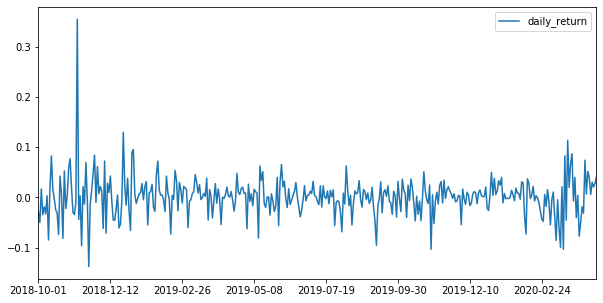

In [19]:
twlo.loc['2018-10-01':, "daily_return"].plot(figsize=(10,5), legend=True);

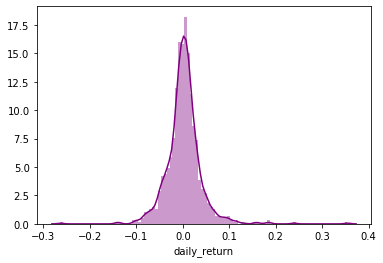

In [20]:
sns.distplot(twlo.daily_return.dropna(), bins=100, color="purple");

In [21]:
def walk_price(s, starting_price, days):
    dt = 1/days
    mu = s.daily_return.mean()
    sigma = s.daily_return.std()

    price = np.zeros(days)
    price[0] = starting_price

    shock = np.zeros(days)
    drift = np.zeros(days)

    for x in range(1, days):
        shock[x] = np.random.normal(loc=mu*dt, scale=sigma*np.sqrt(dt))
        drift[x] = mu * dt
        price[x] = price[x-1] + (price[x-1] * drift[x] + shock[x])
        
    return price

In [25]:
twlo_recent = twlo.iloc[twlo.index > '2020-01-01']

In [27]:
twlo_recent.head()

,open,high,low,close,volume,daily_return
2020-01-02,100.01,103.15,99.66,103.15,2876697.0,0.049552
2020-01-03,101.10,104.55,100.76,103.52,2502762.0,0.003587
2020-01-06,102.74,107.74,101.77,107.46,3938663.0,0.038060
2020-01-07,107.63,109.94,107.37,108.06,2646387.0,0.005583
2020-01-08,108.80,110.82,108.20,109.39,3034975.0,0.012308


Text(0.5, 1.0, 'MC Simulation')

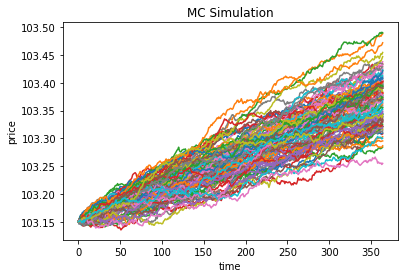

In [37]:
for i in range(100):
    price = walk_price(twlo_recent, 103.15, 365)
    plt.plot(price)
plt.xlabel("time")
plt.ylabel("price")
plt.title("MC Simulation")

In [39]:
runs = 10000

price_sim = np.zeros(runs)

for i in range(runs):
    price_sim[i] = walk_price(twlo_recent, 103.15, 365)[365-1]


In [40]:
price_sim

array([103.36720919, 103.39790296, 103.38898454, ..., 103.30674327,
       103.3698964 , 103.36317203])

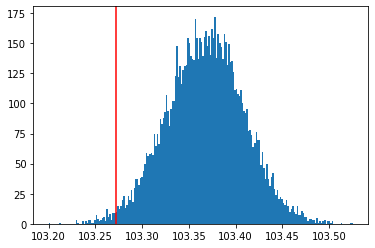

In [46]:
q = np.percentile(price_sim, 1)
plt.hist(price_sim, bins=200);
plt.axvline(q, color="red");